In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u
import pickle as pickle
import os as os
import pandas as pd

from spectools_ir_multicom.utils import extract_hitran_data, spec_convol, make_rotation_diagram, get_molmass
from spectools_ir_multicom.utils import compute_thermal_velocity, sigma_to_fwhm, fwhm_to_sigma, wn_to_k, spec_convol_R
from spectools_ir_multicom.utils import get_miri_mrs_resolution, get_miri_mrs_wavelengths, make_miri_mrs_figure

from spectools_ir_multicom.flux_calculator import calc_fluxes, make_lineshape

from spectools_ir_multicom.slabspec import make_spec, make_spec_multicom

from spectools_ir_multicom.slab_fitter import Config, LineData,Retrieval
from spectools_ir_multicom.slab_fitter import corner_plot, trace_plot, find_best_fit, compute_model_fluxes
from spectools_ir_multicom.slab_fitter import calc_solid_angle, calc_radius
from spectools_ir_multicom.slab_fitter import read_data_from_file, get_samples

### Retrieval testing

In [2]:
lineflux_data=pickle.load(open('lineflux_data.p','rb'))  #restore lineflux_data if you don't want to re-run

In [17]:
myconfig=Config()  #reads config.json by default, or can specify path to file as input parameter
myconfig.display()

data=lineflux_data

mydata=LineData(data)
myretrieval=Retrieval(myconfig,mydata)

{
 "tmin": 100,
 "tmax": 1200,
 "lognmin": 19,
 "lognmax": 24,
 "logomegamin": -19,
 "logomegamax": -12,
 "Nwalkers": 20,
 "Nburnin": 500,
 "Nsamples": 5000,
 "Ncom": 1
}


In [18]:
mychain=myretrieval.run_emcee()  #Run retrieval.  May take a while, depending on number of samples
pickle.dump(mychain,open('test_chain.p','wb'))  #Save for convenience and later retrieval
os.system('afplay /System/Library/Sounds/Sosumi.aiff')

mychain=pickle.load(open('test_chain.p','rb'))  
postsamples=get_samples(mychain,myconfig.getpar('Nburnin'))  #Get list of samples, after removing burnin, from chain

Number of total samples: 100000
Run time [s]: 319.9131920337677


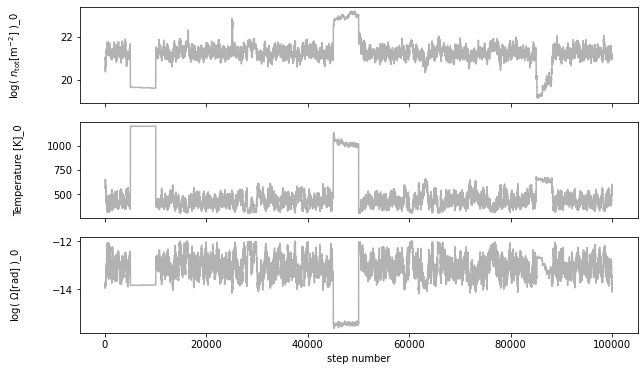

In [20]:
trace_plot(postsamples)

In [21]:
#Best fit parameters - best fit parameters plus/minus 1-sigma intervals
best_fit=find_best_fit(postsamples,show=True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

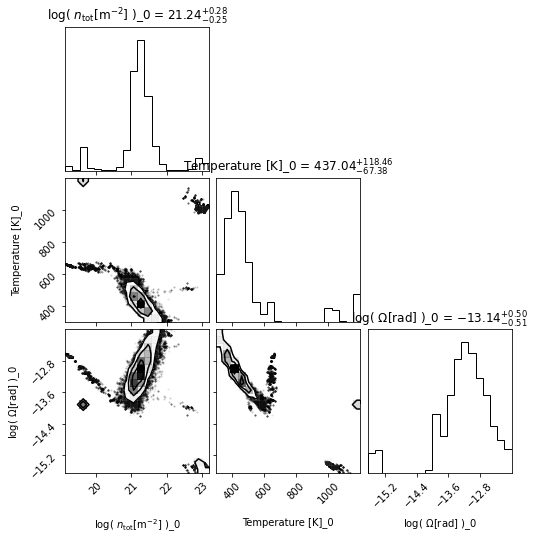

In [22]:
fig=corner_plot(postsamples)

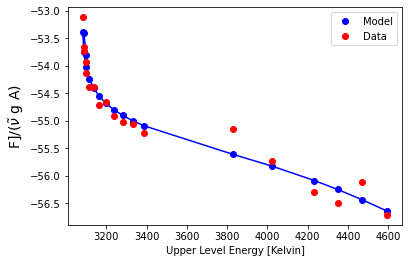

In [23]:
#Rotation diagram
modelflux=compute_model_fluxes(mydata,postsamples) #Compute model fluxes for ecah line in data
rotdiag=mydata.rot_diagram(modelfluxes=modelflux,units='mks') #Rotation diagram for data and model

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rotdiag['x'],rotdiag['modely'],'bo',label='Model')
ax1.plot(rotdiag['x'],rotdiag['modely'],'b',label='_None_')
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')

ax1.set_xlabel('Upper Level Energy [Kelvin]')
#ax1.set_ylabel(r'F[W m$^{-2}$]/($\~{\nu}$ [m$^{-1}$]g A[s$^{-1}$])',fontsize=14)
ax1.set_ylabel(r'F]/($\~{\nu}$ g A)',fontsize=14)
ax1.legend()

### make_spec_multicom testing

In [12]:
n_col_arr=[1e22,2e23,1e21]
temp_arr=[400,600,800]
area_arr=[(2e15)**2.,(1e15)**2.,(1e15)**2.]

model_output=make_spec_multicom('CO',n_col_arr,temp_arr,area_arr, wmin=4.58,wmax=5.2,convol_fwhm=30.,d_pc=140.,vup=1)

Reading partition function from:  https://hitran.org/data/Q/q26.txt
Reading partition function from:  https://hitran.org/data/Q/q26.txt
Reading partition function from:  https://hitran.org/data/Q/q26.txt


(4.7, 4.72)

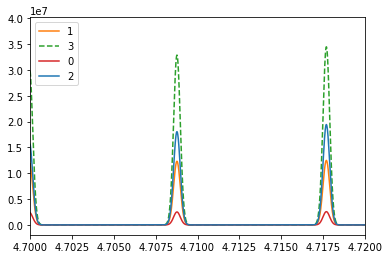

In [17]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(model_output[1]['spectrum']['wave'],model_output[1]['spectrum']['convolflux'],'C1',label='1')
ax1.plot(model_output[3]['wave'],model_output[3]['convolflux'],'C2--',label='3')
ax1.plot(model_output[0]['spectrum']['wave'],model_output[0]['spectrum']['convolflux'],'C3',label='0')
ax1.plot(model_output[2]['spectrum']['wave'],model_output[2]['spectrum']['convolflux'],'C0',label='2')

ax1.legend()
ax1.set_xlim(4.7,4.72)

In [4]:
n_col_arr=[1e22,2e23]
temp_arr=[400,600]
area_arr=[(1e15)**2.,(2e15)**2.]

n_col_arr=np.array(n_col_arr)
temp_arr=np.array(temp_arr)
area_arr=np.array(area_arr)

ncol=np.size(n_col_arr)
ntemp=np.size(temp_arr)
narea=np.size(area_arr)

if(not (ncol==ntemp==narea)):
    print('Column density, temperature, and area lists must have the same number of elements. Exiting.')



In [2]:
import spectools_ir_multicom
print(spectools_ir_multicom.__file__)

/Users/cosalyk/mypy/spectools_ir_multicom/spectools_ir_multicom/__init__.py


# Flux_calculator example use

Flux calculator will loop through a set of provided wavelengths, then perform a Gaussian and numerical computation of line flux at each location.  If one begins by using the helper tool "extract_hitran_data", the output will include transition-specific data in addition to the computed line fluxes.

### Read in HITRAN data with extract_hitran_data

This example uses extract_hitran_data to find fundamental CO vibrational transitions in the M band.  A spectrum is read in from a FITS file.

In [3]:
hitran_data=extract_hitran_data('CO',4.58,5.2,vup=1)  #Outputs an astropy table

In [4]:
#Read in FITS data containing spectrum.
infile='AATau_M.fits'

hdulist=fits.open(infile)
data=hdulist[1].data
wave=data['WAVELENGTH'][0]*1e-3
flux=data['FLUX'][0]

Text(0, 0.5, 'Flux [Jy]')

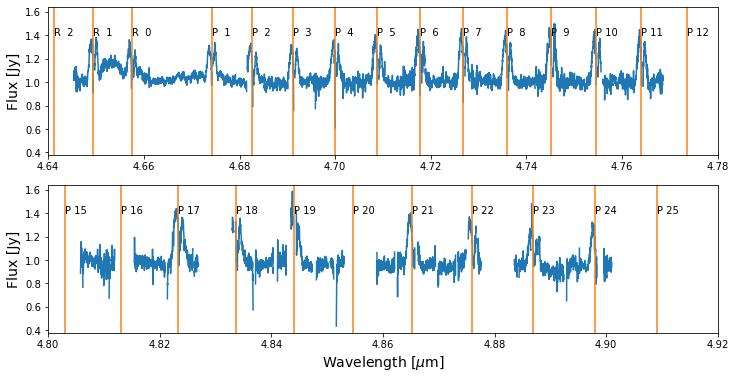

In [5]:
#Plot spectrum.
fig=plt.figure(figsize=(12,6))

ax1=fig.add_subplot(211)
ax1.plot(wave,flux)
ax1.set_xlim(4.64,4.78)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.64) & (mywave<4.78) ):
        ax1.axvline(mywave,color='C1')
        ax1.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
ax1.set_ylabel('Flux [Jy]',fontsize=14)

ax2=fig.add_subplot(212)
ax2.plot(wave,flux)
ax2.set_xlim(4.8,4.92)
for i,mywave in enumerate(hitran_data['wave']):
    if( (mywave>4.8) & (mywave<4.92) ):
        ax2.axvline(mywave,color='C1')
        ax2.text(hitran_data['wave'][i],1.4,hitran_data['Qpp'][i].strip())
ax2.set_xlabel('Wavelength [$\mu$m]',fontsize=14)
ax2.set_ylabel('Flux [Jy]',fontsize=14)

### Calculate line fluxes for dataset, using locations specified in hitran dataset

calc_fluxes is now used to compute the line fluxes in the spectrum.  (Some additional code is added to read and write in the flux values for use in later parts of this notebook.)  Users can provide input values of the continuum level (cont), FWHM (fwhm_v) and Doppler shift of lines relative to vacuum rest wavelength (v_dop).  Users can also choose the size of the fit interval (sep_v), whether or not to vet the fits (vet_fits; highly recommended) and whether or not to plot (highly recommended).   The routine does little to no vetting on its own, so user vetting is highly recommended.

In [2]:
#Calculate fluxes.
#Uncomment the following two lines to run the code
#lineflux_data=calc_fluxes(wave,flux,hitran_data, v_dop=0,fwhm_v=40.,sep_v=200.,cont=1.05,vet_fits=True, plot=True)
#pickle.dump(lineflux_data,open('lineflux_data.p','wb')) #save for convenience

lineflux_data=pickle.load(open('lineflux_data.p','rb'))  #restore lineflux_data if you don't want to re-run

Note that flux_calculator calculates fluxes using both a Gaussian fit and numerical integration.  The numerical integration sums from -3$\sigma$ to +3$\sigma$, where $\sigma$ is provided by the Gaussian fit. These values should be similar for Gaussian line shapes, but may be quite different for more complex line shapes, as for AA Tau. 

The figure below shows how the two compare for this example.

In [7]:
lineflux_data

molec_id,local_iso_id,wn,a,elower,Vp_HITRAN,Vpp_HITRAN,Qp_HITRAN,Qpp_HITRAN,gup,glow,nu,eup_k,wave,lineflux,lineflux_Gaussian,lineflux_err,linewidth,linewidth_err,v_dop_fit,v_dop_fit_err,continuum,continuum_err,wave_fit,wave_fit_err,amp_fit,amp_fit_err
,,,,,,,,,,,,,,W / m2,,W / m2,km / s,km / s,km / s,km / s,Jy,Jy,micron,micron,Jy,Jy
int32,int32,float32,float32,float32,bytes15,bytes15,bytes15,bytes15,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5,1,2041.6665,15.42,1151.315,1,0,,P 24,47.0,49.0,61207625000000.0,4593.988,4.8979597,3.486068185752503e-17,3.5705542293870424e-17,4.652459594167097e-18,46.59827657508426,1.763406039513457,-22.463162466826066,0.6885178171916984,0.9392412654994879,0.0037733512439725027,4.89759270972581,1.1248890482924953e-05,0.3525463595232763,0.011038264373568103
5,1,2046.2761,15.53,1059.3718,1,0,,P 23,45.0,47.0,61345815000000.0,4468.3345,4.886926,6.083405538436904e-17,6.273247410293018e-17,1.8459815049138492e-17,124.51306235202964,8.731928806624056,-13.529067622487888,2.738244637888512,0.9272977586104211,0.007507847840848472,4.886705636412077,4.463621093550358e-05,0.23129245731622836,0.011426945432856094
5,1,2050.8542,15.65,971.2332,1,0,,P 22,43.0,45.0,61483065000000.0,4348.1094,4.876017,4.0558149737181455e-17,3.908310301334667e-17,8.223263904126658e-18,52.86601758274415,4.035215009275286,-30.292823198690805,1.7133831814306508,0.9888641219799166,0.007139724207234817,4.875524391724858,2.786756456909515e-05,0.33861139161676773,0.016803711058075772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,1,2139.426,34.75,3.845,1,0,,P 1,1.0,3.0,64138382000000.0,3083.6885,4.674151,6.333898524068087e-17,6.563514838823506e-17,1.661946571465891e-17,135.99260667123718,8.081014299684256,2.930246468631021,2.352703262199478,1.0293570813130526,0.00635993509782237,4.674196630076527,3.668167720679536e-05,0.21193170933242916,0.00929608815566913
5,1,2147.081,11.71,0.0,1,0,,R 0,3.0,1.0,64367874000000.0,3089.1704,4.657486,3.5110799930022414e-17,3.63883259439645e-17,1.4000419041305715e-17,111.04506596408937,9.542631211071763,-15.34381742307868,3.3002734164016925,1.074640341739095,0.00519605673244426,4.657247584955793,5.127206071131064e-05,0.14337054157976525,0.009761305872839751
5,1,2150.856,14.13,3.845,1,0,,R 1,5.0,3.0,64481040000000.0,3100.1338,4.649312,5.760293015495106e-17,6.434058922288713e-17,2.1943235607091032e-17,115.02624887891186,9.120092294866224,11.588560371655138,2.892212362960142,1.0527246565799504,0.008091136548388984,4.649491739790021,4.4853689086527604e-05,0.24432130919282966,0.015353515831413608


Text(0, 0.5, 'Line flux [10$^{-16}$ W m$^{-2}$]')

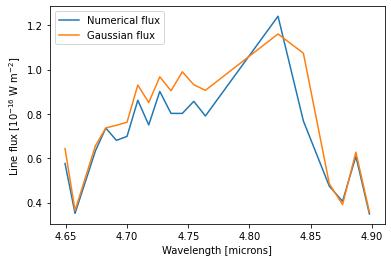

In [21]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux']*1e16, label='Numerical flux')
ax1.plot(lineflux_data['wave'],lineflux_data['lineflux_Gaussian']*1e16 ,label='Gaussian flux')
ax1.legend()
ax1.set_xlabel('Wavelength [microns]')
ax1.set_ylabel(r'Line flux [10$^{-16}$ W m$^{-2}$]')

Note that, although calc_fluxes takes a full "hitran_data" table as input, the most minimal table it can function with is one that just contains a column named "wave", which holds wavelengths in microns.

Not enough data near  5.188746452331543  microns. Skipping.
Not enough data near  5.174523830413818  microns. Skipping.
Not enough data near  5.160454273223877  microns. Skipping.
Not enough data near  5.146536350250244  microns. Skipping.
Not enough data near  5.132768630981445  microns. Skipping.
Not enough data near  5.119149684906006  microns. Skipping.
Not enough data near  5.105678558349609  microns. Skipping.
Not enough data near  5.092352867126465  microns. Skipping.
Not enough data near  5.079172134399414  microns. Skipping.
Not enough data near  5.066134452819824  microns. Skipping.
Not enough data near  5.053239345550537  microns. Skipping.
Not enough data near  5.040484428405762  microns. Skipping.
Not enough data near  5.02786922454834  microns. Skipping.
Not enough data near  5.015391826629639  microns. Skipping.
Not enough data near  5.003051280975342  microns. Skipping.
Not enough data near  4.990846633911133  microns. Skipping.
Not enough data near  4.978776931762695  

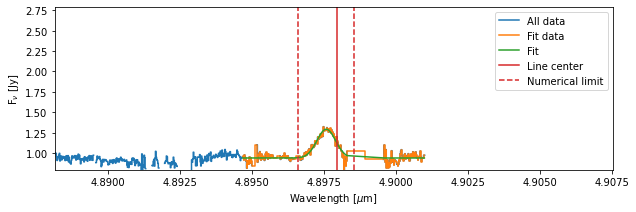

Is this fit okay? [y or n]n


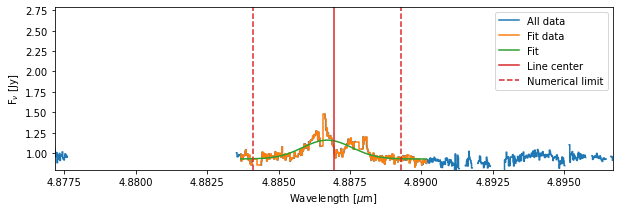

Is this fit okay? [y or n]y


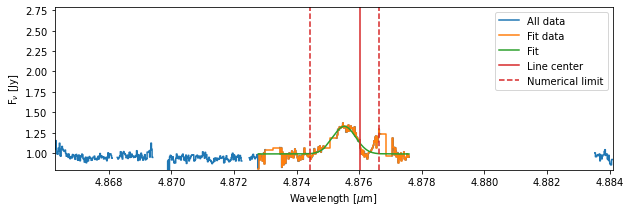

Is this fit okay? [y or n]n


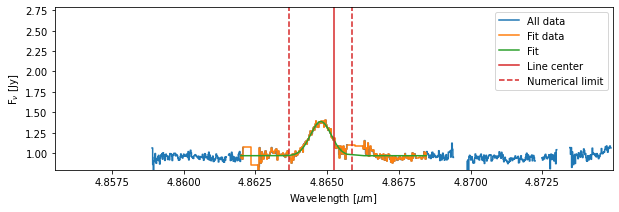

Is this fit okay? [y or n]n


/Users/cosalyk/anaconda3/lib/python3.7/site-packages/spectools_ir/flux_calculator/helpers.py:188: RuntimeWarning: Mean of empty slice
  dwave=np.nanmean(np.diff(myx[mybool]))


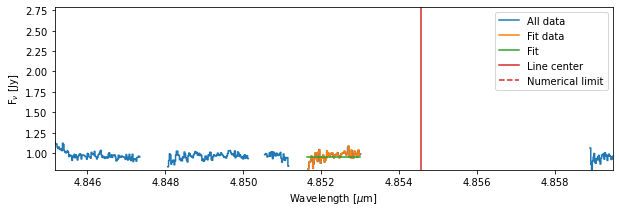

Is this fit okay? [y or n]n


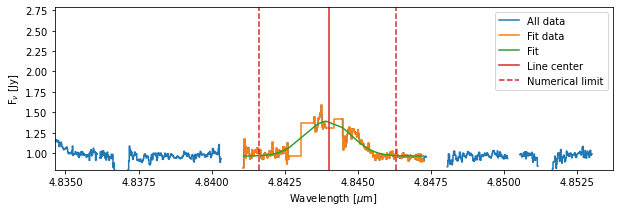

Is this fit okay? [y or n]y
Error - curve_fit failed


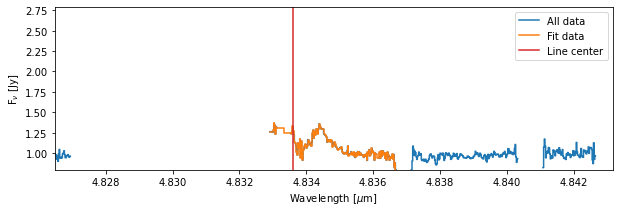

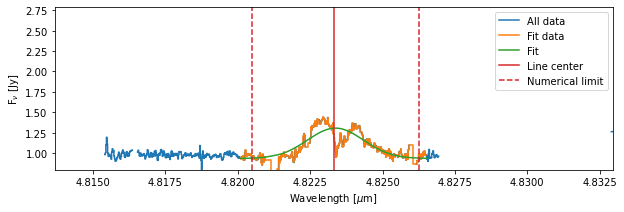

Is this fit okay? [y or n]y


/Users/cosalyk/anaconda3/lib/python3.7/site-packages/spectools_ir/flux_calculator/helpers.py:188: RuntimeWarning: Mean of empty slice
  dwave=np.nanmean(np.diff(myx[mybool]))


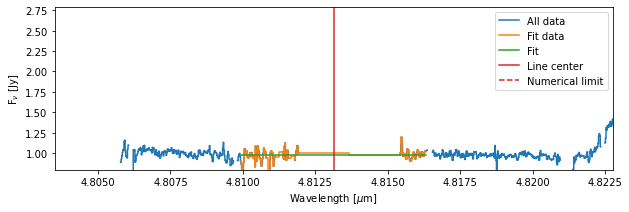

Is this fit okay? [y or n]n


/Users/cosalyk/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/cosalyk/anaconda3/lib/python3.7/site-packages/spectools_ir/flux_calculator/helpers.py:188: RuntimeWarning: Mean of empty slice
  dwave=np.nanmean(np.diff(myx[mybool]))


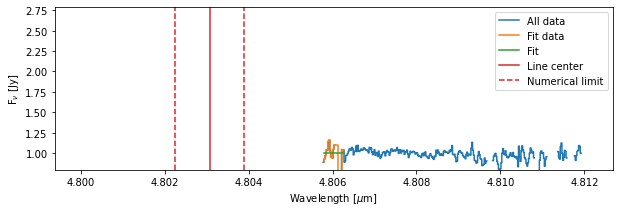

Is this fit okay? [y or n]n
Not enough data near  4.793123722076416  microns. Skipping.
Not enough data near  4.78329610824585  microns. Skipping.
Not enough data near  4.77358341217041  microns. Skipping.


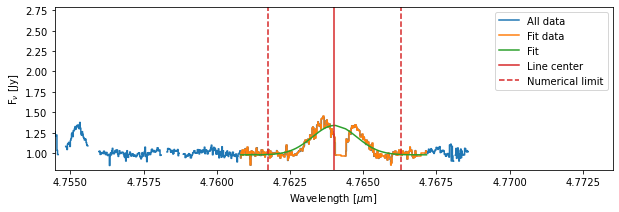

Is this fit okay? [y or n]y


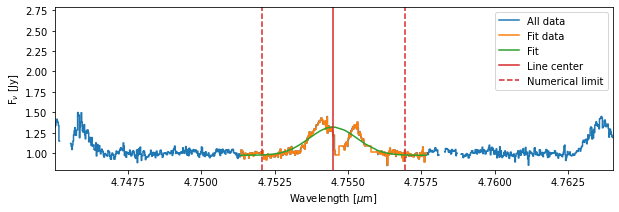

Is this fit okay? [y or n]y


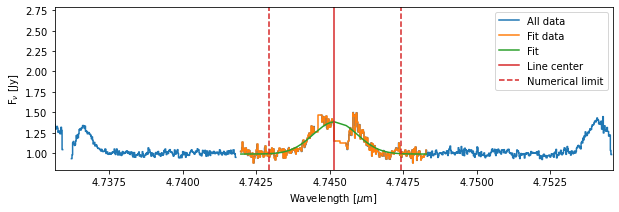

Is this fit okay? [y or n]y


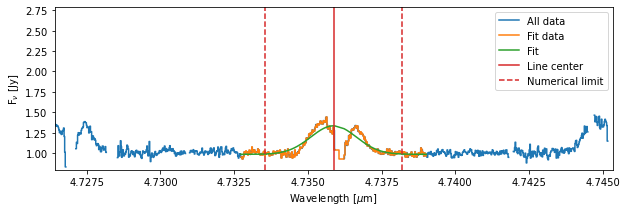

Is this fit okay? [y or n]y


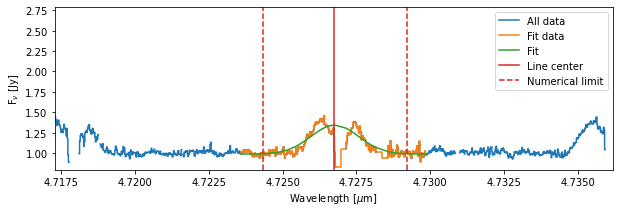

Is this fit okay? [y or n]y


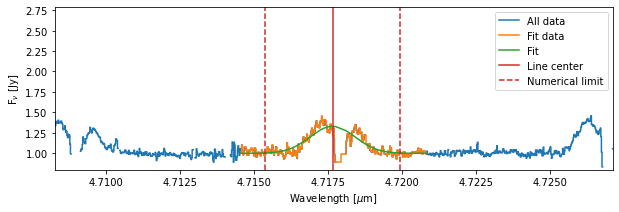

Is this fit okay? [y or n]y


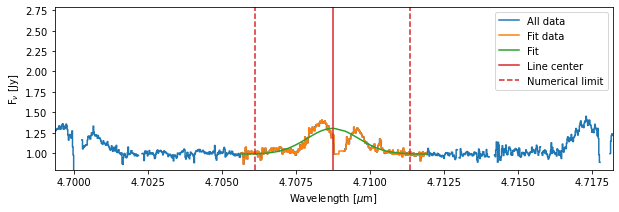

Is this fit okay? [y or n]y


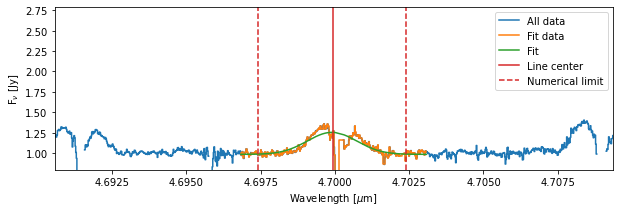

Is this fit okay? [y or n]y


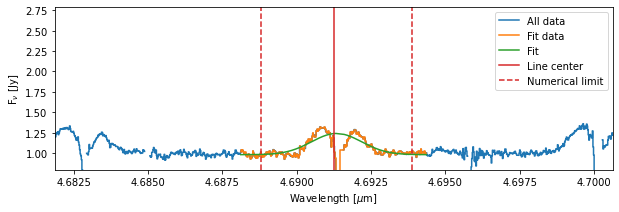

Is this fit okay? [y or n]y


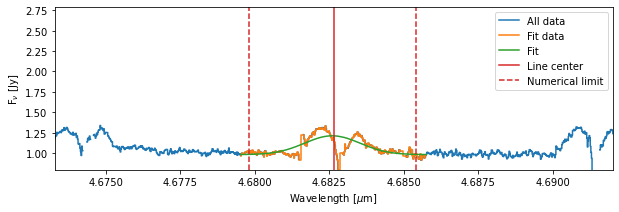

Is this fit okay? [y or n]y


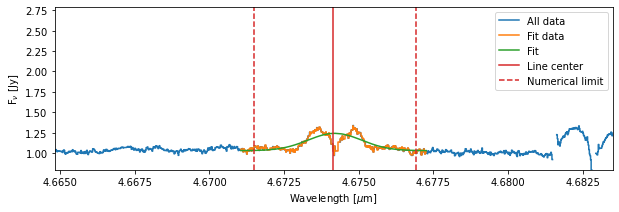

Is this fit okay? [y or n]y


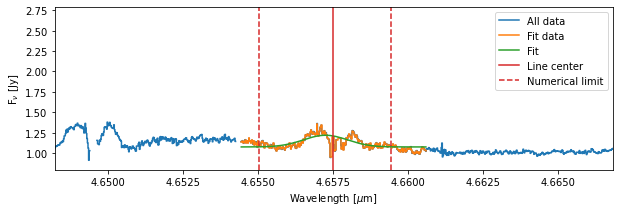

Is this fit okay? [y or n]y


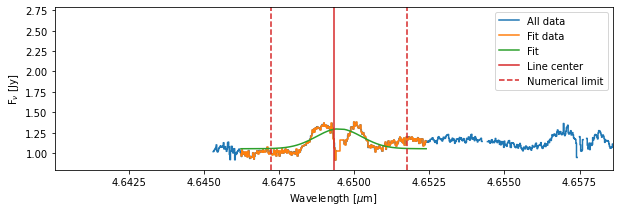

Is this fit okay? [y or n]y
Not enough data near  4.641242027282715  microns. Skipping.
Not enough data near  4.633276462554932  microns. Skipping.
Not enough data near  4.625414848327637  microns. Skipping.
Not enough data near  4.6176557540893555  microns. Skipping.
Not enough data near  4.60999870300293  microns. Skipping.
Not enough data near  4.602443695068359  microns. Skipping.
Not enough data near  4.594989776611328  microns. Skipping.
Not enough data near  4.5876359939575195  microns. Skipping.
Not enough data near  4.580382347106934  microns. Skipping.


In [44]:
#Create minimal hitran database for testing.  It only includes wavelengths.
test_hitran_data=hitran_data[['wave']].copy()

test_lineflux_data=calc_fluxes(wave,flux,test_hitran_data,v_dop=0,fwhm_v=40.,sep_v=200.,cont=1.05,vet_fits=True, plot=True)

You get out what you put in, though, so your output table will only have wavelengths and fit parameters (no HITRAN transition information).

In [45]:
test_lineflux_data

wave,lineflux,lineflux_Gaussian,lineflux_err,linewidth,linewidth_err,v_dop_fit,v_dop_fit_err,continuum,continuum_err
,W / m2,,W / m2,km / s,km / s,km / s,km / s,Jy,Jy
float32,float64,float64,float64,float64,float64,float64,float64,float64,float64
4.886926,6.083405538436904e-17,6.273247410293018e-17,1.8459815049138492e-17,124.51306235202964,8.731928806624056,-13.529067622487888,2.7382446378885117,0.9272977586104211,0.007507847840848472
4.8440294,7.681455013325703e-17,1.0740880348156518e-16,1.5731447202302007e-17,114.03588618186656,5.204636993635021,-3.283572596183353,1.9216616195132408,0.9628299723230958,0.006630784515856071
4.823311,1.2408912386638676e-16,1.1610312535794688e-16,2.793917684606405e-17,141.33648023390248,7.99075142311896,3.9551822398124967,2.311408400160388,0.9332484529350803,0.011907432866002583
4.7639856,7.906968870330044e-17,9.065788854862056e-17,1.7373988639823818e-17,112.61073320974364,5.064331790309218,2.283086367713034,1.6298595801035067,0.9778634708041147,0.006887433665049476
4.754502,8.567536502293876e-17,9.318355633517686e-17,1.7915788055691295e-17,120.51363071732213,5.6964490870477915,-0.5799526307532313,1.7964240616913956,0.9724873691688937,0.006669513014516189
4.745131,8.022737517688595e-17,9.899888694175797e-17,1.660936369593039e-17,111.69249259228411,4.402139721337425,3.571105905777028,1.5016350216321153,0.9876200469243724,0.006208320696338367
4.735873,8.023963439974691e-17,9.044590155643528e-17,1.6278245169425356e-17,115.09082410404514,4.743584824605865,0.009417240145324832,1.5409373135691893,0.9841959309887417,0.00604538787077957
4.726727,9.01521244590666e-17,9.675632432483886e-17,1.9469202757387623e-17,121.13576751180577,5.845291929288854,2.362160590364922,1.8160622164085398,0.9872864159657103,0.007225961226264244


### Create a composite lineshape using info from flux_calculator output

Flux calculator also has a routine that can make a composite lineshape from calc_fluxes output.

In [22]:
lineshape_data=make_lineshape(wave,flux,lineflux_data)

Text(0, 0.5, 'Arbitrary flux')

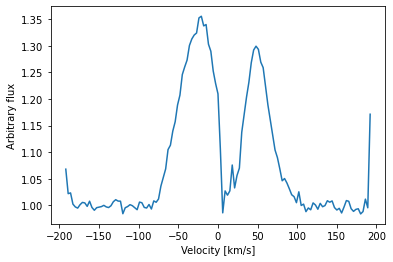

In [23]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineshape_data[0],lineshape_data[1])

ax1.set_xlabel('Velocity [km/s]')
ax1.set_ylabel('Arbitrary flux')

As with calc_fluxes, the routine can work with a minimal input table that includes a column named 'wave'.

Text(0, 0.5, 'Arbitrary flux')

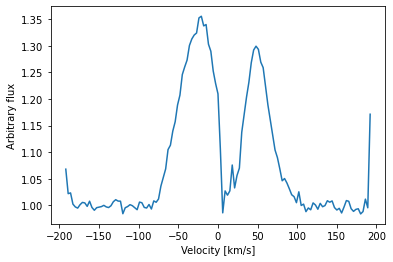

In [24]:
lineflux_data_minimal=lineflux_data['wave'].copy()
lineshape_data_minimal=make_lineshape(wave,flux,lineflux_data)

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(lineshape_data_minimal[0],lineshape_data_minimal[1])

ax1.set_xlabel('Velocity [km/s]')
ax1.set_ylabel('Arbitrary flux')

### Display resultant fluxes in a rotation diagram

Spectools_ir.utils has a function to make a rotation diagram, which can use calc_fluxes output as its dataset.  This example compares rotation diagrams for the Gaussian and numerical fluxes.

make_rotation_diagrams has a "units" keyword with values 'mks' (SI), 'cgs', or 'mixed'. Based on some precedent in the literature, 'mixed' units keeps most values in SI units, but wavenumbers in inverse cm.

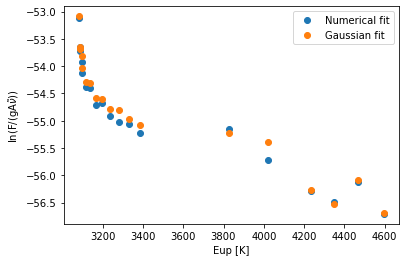

In [25]:
rot_numerical=make_rotation_diagram(lineflux_data,fluxkey='lineflux')
rot_Gaussian=make_rotation_diagram(lineflux_data,fluxkey='lineflux_Gaussian')

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rot_numerical['x'],rot_numerical['y'],'C0o',label='Numerical fit')
ax1.plot(rot_Gaussian['x'],rot_Gaussian['y'],'C1o', label='Gaussian fit')

ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.legend()

# Slabspec example use

Slabspec makes a model spectrum from a "slab" of gas - a column of gas with defined area, column density, and (single) temperature. The example below shows the creation of a CO spectrum from 4.58 to 5.2 microns.  Units are assumed to be SI (mks).  If convol_fwhm is specified, the model output will be convolved with a Gaussian with the given FWHM value (in km/s).  Both the convolved and unconvolved spectra are included in the output.

**Important note**: The model can produce wonky output if the model resolution ('res' parameter: resolution in microns) is not sufficient.  It's highly recommended that one check the output of a model against a model with higher resolution to make sure the output remains the same.

### Make a slab model spectrum with make_spec

In [8]:
au=1.5e11
#Make slab model
#This can take a few seconds to run.  It is primarily limited by the convolution time.
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.58,wmax=5.2,convol_fwhm=30.,d_pc=140.,vup=1)

Reading partition function from:  https://hitran.org/data/Q/q26.txt


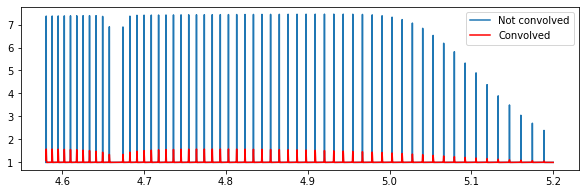

In [9]:
#Plot slab model
fig=plt.figure(figsize=(10,3))
ax1=fig.add_subplot(111)
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['flux']+1,label='Not convolved')
ax1.plot(model_output['spectrum']['wave'],model_output['spectrum']['convolflux']+1,'r',label='Convolved')
ax1.legend()

### Output model fluxes as a rotation diagram (compare to data if desired)

Output from slabspec can also be displayed as a rotation diagram.

In [10]:
rd_model=make_rotation_diagram(model_output['lineparams'])
rd_data=make_rotation_diagram(lineflux_data)

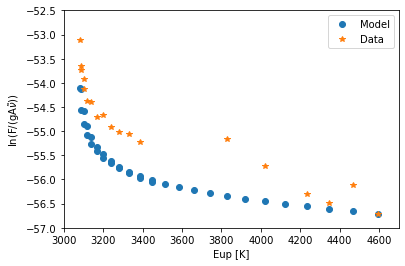

In [11]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rd_model['x'],rd_model['y'],' C0o',label='Model')
ax1.plot(rd_data['x'],rd_data['y'],' C1*',label='Data')
ax1.set_xlabel('Eup [K]')
ax1.set_ylabel(r'ln(F/(gA$\tilde{\nu}$))')
ax1.set_xlim(3000,4700)
ax1.set_ylim(-57,-52.5)
ax1.legend()

# Slab_fitter example use

slab_fitter uses the MCMC fitting code "emcee" to fit line fluxes with a slab model.  Priors are assumed to be flat, with boundaries provided by the user as input parameters.

In contrast to the slab model, slab_fitter uses solid angle in place of area.  Helper functions calc_solid_angle(radius, distance) and calc_radius(solid_angle,distance) can be used to convert between the two.  Calculations assume a face-on disk shape.

### Set up configuration

Configuration parameters are all stored in config.json, or another user-specified json file.  User must specify the range of temperatures, column densities, and solid angles, the number of walkers, the number of burnin samples, and the number of samples per walker.

slab_fitter naturally takes output of flux_calculator as input. (Other input examples are discussed below).

In [3]:
myconfig=Config()  #reads config.json by default, or can specify path to file as input parameter
myconfig.display()

data=lineflux_data

mydata=LineData(data)
myretrieval=Retrieval(myconfig,mydata)

{
 "tmin": 100,
 "tmax": 1200,
 "lognmin": 19,
 "lognmax": 24,
 "logomegamin": -19,
 "logomegamax": -12,
 "Nwalkers": 5,
 "Nburnin": 10,
 "Nsamples": 300,
 "Ncom": 1
}


### Run retrieval

Running the retrieval can take a significant amount of time, so only run when ready. (Code below currently takes 9 minutes on my personal laptop.)

In [4]:
mychain=myretrieval.run_emcee()  #Run retrieval.  May take a while, depending on number of samples
pickle.dump(mychain,open('test_chain.p','wb'))  #Save for convenience and later retrieval
os.system('afplay /System/Library/Sounds/Sosumi.aiff')

mychain=pickle.load(open('test_chain.p','rb'))  
postsamples=get_samples(mychain,myconfig.getpar('Nburnin'))  #Get list of samples, after removing burnin, from chain

RuntimeError: It is unadvisable to use a red-blue move with fewer walkers than twice the number of dimensions.

### Evaluate retrieval results

slab_fitter includes a few simple routines for evaluating and viewing the retrieval results.

**Note:** The examples here are not necessarily well-behaved samples.  Users should refer to emcee documentation and other sources for more info about MCMC sample vetting.

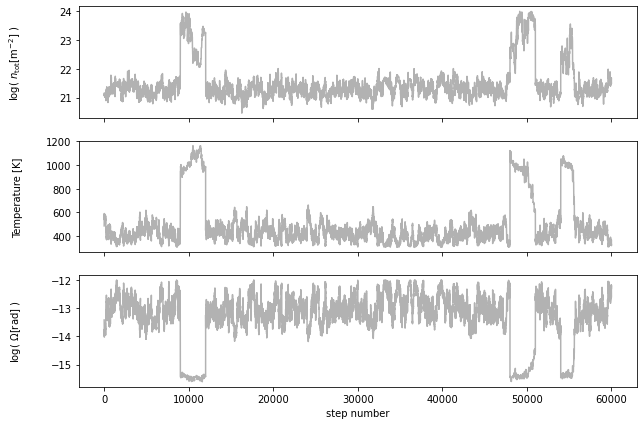

In [15]:
#Trace plot - examine samples
trace_plot(postsamples)

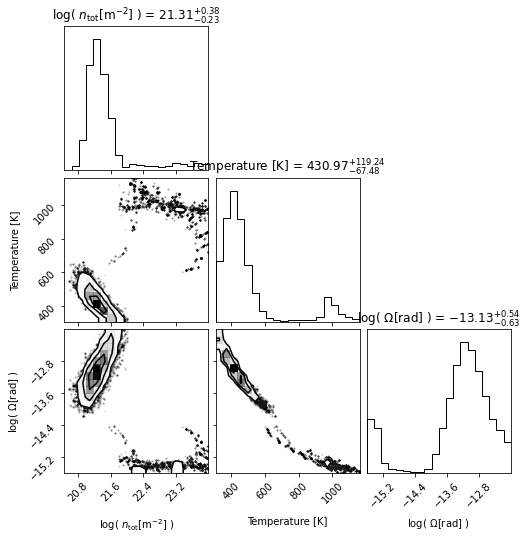

In [16]:
#Corner plot - see posterior distributions
fig=corner_plot(postsamples)

In [17]:
#Best fit parameters - best fit parameters plus/minus 1-sigma intervals
best_fit=find_best_fit(postsamples,show=True)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

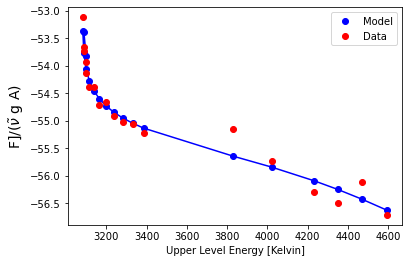

In [18]:
#Rotation diagram
modelflux=compute_model_fluxes(mydata,postsamples) #Compute model fluxes for ecah line in data
rotdiag=mydata.rot_diagram(modelfluxes=modelflux,units='mks') #Rotation diagram for data and model

fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(rotdiag['x'],rotdiag['modely'],'bo',label='Model')
ax1.plot(rotdiag['x'],rotdiag['modely'],'b',label='_None_')
ax1.plot(rotdiag['x'],rotdiag['y'],'ro',label='Data')

ax1.set_xlabel('Upper Level Energy [Kelvin]')
#ax1.set_ylabel(r'F[W m$^{-2}$]/($\~{\nu}$ [m$^{-1}$]g A[s$^{-1}$])',fontsize=14)
ax1.set_ylabel(r'F]/($\~{\nu}$ g A)',fontsize=14)
ax1.legend()

While slab_fitter naturally works with flux_calculator output, the "read_data_from_file" routine is provided as a way to read a minimal column-delimited file, and output a slab_fitter-ready data frame.  A file must contain the columns:  'molec' (e.g., "H2O"), 'iso' (1 for most common, 2 for second most common, etc.),'lineflux' (W/m$^2$), 'error'  (W/m$^2$), and either 'wn'(cm$^{-1}$) or 'wave' (microns).  

**Important note**: read_data_from_file will use your input molecular parameters and wavelength or wavenumber to find other transition parameters in the HITRAN database.  Since it has limited information, it simply finds the transition with the closest wavelength.  Therefore, the wavelengths must be precise.  It's a good idea to check the output before proceeding further, to make sure the transitions are what you expect.

In [19]:
!cat 'slab_fitter_input.txt'

data=read_data_from_file('slab_fitter_input.txt')

molec iso  wn           lineflux   error
H2O   1    816.4532      5.95e-18  1.46e-18
H2O   1    815.3016      7.79e-18  1.76e-18 
H2O   1    814.5180      8.89e-18  1.73e-18 
H2O   1    808.0351     29.1e-18   3.9e-18 
H2O   1    806.6988     22.3e-18   3.7e-18 
H2O   1    805.9966     11.3e-18   4.2e-18 
H2O   1    803.5485     15.8e-18   5.6e-18 
H2O   1    802.9871     13.5e-18   4.7e-18 



In [20]:
data  #Are these the transitions you want?

,molec,wn,lineflux,local_iso_id,molec_id,lineflux_err,a,gup,elower,eup_k
0,H2O,816.4532,5.950000e-18,1,1,1.460000e-18,7.7250,35.0,3211.055176,5794.685925
1,H2O,815.3016,7.790000e-18,1,1,1.760000e-18,12.2800,111.0,4017.909424,6953.912265
2,H2O,814.5180,8.890000e-18,1,1,1.730000e-18,0.5009,75.0,1998.995239,4048.017793
3,H2O,808.0351,2.910000e-17,1,1,3.900000e-18,4.2070,99.0,2631.268799,4948.390924
4,H2O,806.6988,2.230000e-17,1,1,3.700000e-18,7.6100,105.0,3211.212646,5780.878085
5,H2O,805.9966,1.130000e-17,1,1,4.200000e-18,4.1900,33.0,2631.283447,4945.479054
6,H2O,803.5485,1.580000e-17,1,1,5.600000e-18,0.2930,69.0,1718.718750,3628.979798
7,H2O,802.9871,1.350000e-17,1,1,4.700000e-18,1.0370,81.0,2124.951416,4212.650236


In [25]:
myconfig=Config()  #reads config.json by default, or can specify path to file
myconfig.display()

mydata=LineData(data)
#myretrieval=Retrieval(myconfig,mydata)  #Commented out because this line of code takes a long time to run.

{
 "tmin": 100,
 "tmax": 2000,
 "lognmin": 19,
 "lognmax": 24,
 "logomegamin": -19,
 "logomegamax": -12,
 "Nwalkers": 20,
 "Nburnin": 1000,
 "Nsamples": 3000
}


# Example use of some utils functions

spectools_ir.utils contains a few other commonly-used utilities that one may find helpful for analyis of IR spectroscopy, including some routines specific to JWST-MIRI MRS.

### Extract HITRAN data for any molecule in the database

In [21]:
hitran_data=extract_hitran_data('CH3OH',10,11,isotopologue_number=1,eupmax=5000,aupmin=0.1)  #Outputs an astropy table

In [22]:
hitran_data

molec_id,local_iso_id,wn,sw,a,gamma_air,gamma_self,elower,n_air,delta_air,Vp,Vpp,Qp,Qpp,ierr1,ierr2,ierr3,ierr4,ierr5,ierr6,iref1,iref2,iref3,iref4,iref5,iref6,line_mixing_flag,gp,gpp,nu,eup_k,wave
int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,bytes15,bytes15,bytes15,bytes15,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,int32,bytes1,float32,float32,float32,float32,float32
39,1,970.0117,2.762e-23,6.098,0.1,0.4,1308.2999,0.75,0.0,V8,GROUND,33 10 A+,34 10 A+,6,4,2,2,2,0,1,1,1,1,1,0,,134.0,138.0,29080221000000.0,3277.982,10.309154
39,1,970.0117,4.178e-23,9.225,0.1,0.4,1308.2999,0.75,0.0,V8,GROUND,33 10 A-,34 10 A-,6,4,2,2,2,0,1,1,1,1,1,0,,134.0,138.0,29080221000000.0,3277.982,10.309154
39,1,970.08594,2.667e-22,17.68,0.1,0.4,1034.6189,0.75,0.0,V8+V12,V12,29 1 E2,30 1 E2,6,4,2,2,2,0,1,1,1,1,1,0,,118.0,122.0,29082446000000.0,2884.3228,10.308365
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39,1,999.94727,8.346e-21,29.19,0.1,0.4,321.1012,0.75,0.0,V8,GROUND,18 1 E1,19 1 E1,6,4,2,2,2,0,1,1,1,1,1,0,,74.0,78.0,29977666000000.0,1900.6937,10.000527
39,1,999.95917,1.323e-22,38.91,0.1,0.4,1273.1111,0.75,0.0,V8+V12,V12,22 13 E1,23 13 E1,6,4,2,2,2,0,1,1,1,1,1,0,,90.0,94.0,29978022000000.0,3270.4407,10.000408
39,1,999.982,1.894e-22,7.675,0.1,0.4,846.2081,0.75,0.0,V8+2V12,2V12,20 1 A-,21 1 A-,6,4,2,2,2,0,1,1,1,1,1,0,,82.0,86.0,29978706000000.0,2656.2554,10.00018
39,1,999.9841,1.095e-21,32.09,0.1,0.4,769.2384,0.75,0.0,V8+2V12,2V12,19 3 E1,20 3 E1,6,4,2,2,2,0,1,1,1,1,1,0,,78.0,82.0,29978770000000.0,2545.5159,10.000159


### Convolve a spectrum with a Gaussian spectral response function

Note: Convolving a spectrum is conceptually simple, but edge effects and NaNs in spectral data can cause headaches.  This routine deals nicely with both of those issues (though it's not fast)

In [23]:
au=1.5e11
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.6,wmax=4.62,d_pc=140.)
wave=model_output['spectrum']['wave']
flux=model_output['spectrum']['flux']
convolflux=spec_convol(wave,flux,30.)  #Inputs: wavelength, flux, FWHM of Gaussian SRF in km/s

Reading partition function from:  https://hitran.org/data/Q/q26.txt


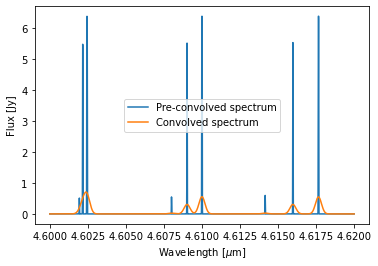

In [24]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(wave,flux,label='Pre-convolved spectrum')
ax1.plot(wave,convolflux,label='Convolved spectrum')
ax1.set_xlabel(r'Wavelength [$\mu$m]')
ax1.set_ylabel('Flux [Jy]')
ax1.legend()

### Convolve spectrum with a wavelength-dependent SRF

A utility function is provided that allows for a wavelength-dependent spectral response function (SRF).  Input spectral resolution must either be a single element (i.e., non wavelength-dependent) or have the same number of elements as the spectrum.  Note the resolution is given as $R = \frac{\lambda}{\Delta \lambda}$ rather than $v$ in this function.

In [25]:
au=1.5e11
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.6,wmax=4.62,d_pc=140.)
wave=model_output['spectrum']['wave']
flux=model_output['spectrum']['flux']
myR=np.linspace(10000,25000.,num=np.size(wave))
convolflux=spec_convol_R(wave,flux,myR)  #Inputs: wavelength, flux, spectral resolution of Gaussian SRF
                                         #myR must either have 1 value, or be an array of same size as wave and flux

Reading partition function from:  https://hitran.org/data/Q/q26.txt


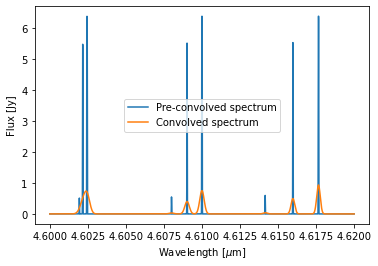

In [26]:
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(wave,flux,label='Pre-convolved spectrum')
ax1.plot(wave,convolflux,label='Convolved spectrum')
ax1.set_xlabel(r'Wavelength [$\mu$m]')
ax1.set_ylabel('Flux [Jy]')
ax1.legend()

#Note the wavelength-dependent line width

### Some utility functions specific to JWST MIRI-MRS

A simple routine is provided to approximate Figure 14 from Wells et al. 2015, which provides R as a function of wavelength.  This function utilizes linear approximations and should only be used as a rough reference.

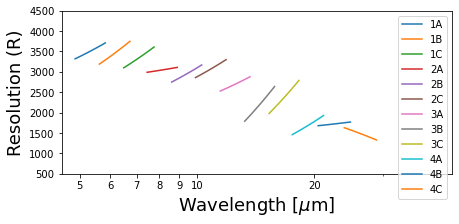

In [27]:
make_miri_mrs_figure(figsize=(7,3))

get_miri_mrs_wavelengths provides the wavelength limits of an MRS sub-band

In [28]:
get_miri_mrs_wavelengths('1A')

(4.87, 5.82)

The covolution routine can be combined with slabspec output to create a model with a wavelength-dependent SRF

Reading partition function from:  https://hitran.org/data/Q/q26.txt


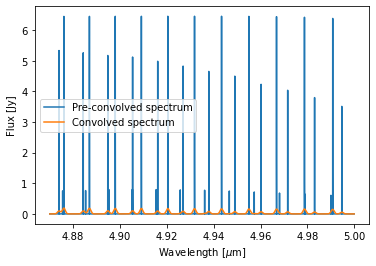

In [30]:
#Get resolution for a range of wavelengths and use as input to wavelength-dependent convolution
au=1.5e11
model_output=make_spec('CO',1e22,1000,np.pi*(0.3*au)**2., wmin=4.87,wmax=5.,d_pc=140.)
wave=model_output['spectrum']['wave']
flux=model_output['spectrum']['flux']

#Use get_miri_mrs_resolution to get wavelength resolution array
myR=get_miri_mrs_resolution('1A',wave)

convolflux=spec_convol_R(wave,flux,myR)  #Inputs: wavelength, flux, spectral resolution of Gaussian SRF
                
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(wave,flux,label='Pre-convolved spectrum')
ax1.plot(wave,convolflux,label='Convolved spectrum')
ax1.set_xlabel(r'Wavelength [$\mu$m]')
ax1.set_ylabel('Flux [Jy]')
ax1.legend()

### Other small helper functions

In [31]:
print(sigma_to_fwhm(20.))

print(fwhm_to_sigma(47.096))

print(get_molmass('H2O',isotopologue_number=2))

print(compute_thermal_velocity('H2',500.))
print(compute_thermal_velocity('H2',1000.))

print(wn_to_k(2000./u.cm))

47.09640090061899
19.999829753182272
20.014811
1436.1325755292241
2030.998165679232
2877.553755007867 K
